# MWC - Assignment04

[Davide Grandesso](mailto:davide.grandesso@usi.ch)

In [1]:
###############
# Some methods and functions to support our analysis
# NOTE: this code is not shown in the slides, but you should run it!
# Feel free to give a look on how we load the data, extract features and all others
# methods we did not describe explicitly in the lecture
###############

# imports
import numpy as np
import pandas as pd
from typing import Literal
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

from scipy.signal import butter, lfilter, filtfilt
from pandas import Series, DataFrame
from numpy import ndarray

from plotly import __version__
from plotly.offline import (
    download_plotlyjs,
    init_notebook_mode,
    plot,
    iplot,
)

init_notebook_mode(connected=True)
import plotly.offline as offline
import plotly.graph_objs as go

from neurokit2.eda import eda_peaks
from warnings import warn

from time import time
from sys import getsizeof

from json import load as load_json
from typing import Any

from logging import getLogger
from typing import Any
from numpy import ndarray, mean, std, gradient, isnan, array
from scipy.stats import linregress
from neurokit2.eda import eda_peaks


# Set notebook mode to work in offline
offline.init_notebook_mode(connected=True)


def butter_lowpass_filter_filtfilt(
    data: Series, cutoff: float, fs: int, order: int
) -> ndarray:
    """Method to create and then apply a digital filter forward and backward to a signal.

    Args:
        data (ndarray): timeseries to be filtered, e.g. EDA data signal
        cutoff (float): cutoff point for the lowpass, e.g. `5`
        fs (int): frequency of the singal, e.g. `64`
        order (int): order for the filter, e.g. `2`

    Returns:
        ndarray: returns the data filtered
    """
    b, a = butter_lowpass(cutoff, fs, order=order)
    if isinstance(data, DataFrame):
        y: ndarray = filtfilt(b=b, a=a, x=data.iloc[:, 0].values)
        y = stack([y, data.iloc[:, 1].values], axis=1)
    elif isinstance(data, Series):
        y: ndarray = filtfilt(b=b, a=a, x=data.values)
    else:
        raise TypeError(
            f"The method takes as input either pandas Dataframe or Series objects. Recevied {type(data)} instead"
        )
    return y


def butter_lowpass(
    cutoff: float, fs: int, order: int
) -> tuple[float, float]:
    """Figure out the numerator (`b`) and denominator (`a`) coefficients for a linear digital
    filter

    Args:
        cutoff (float): cutoff value
        fs (int): frequency of the signal
        order (int): order for the Butterworth filter

    Returns:
        (tuple): numerator and denominator coefficients for the lowpass filter
    """
    # NOTE: Nyquist frequeny is half the sampling frequency
    nyq = 0.5 * fs
    # NOTE: Normalization of the cutoff signal
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a


def make_interactive_lineplot(
    data: pd.DataFrame,
    x: str | Literal["index"] | list[str | Literal["index"]],
    y: str | Literal["index"] | list[str | Literal["index"]],
    name: str | list[str],
    title: str,
    xlabel: str = "",
    ylabel: str = "",
    **kwargs,
):
    traces = list()
    if (
        isinstance(x, list)
        and isinstance(y, list)
        and isinstance(name, list)
    ):
        for x_val, y_val, name_val in zip(x, y, name):
            trace = go.Scatter(
                x=data[x_val] if x_val != "index" else data.index,
                y=data[y_val] if y_val != "index" else data.index,
                name=name_val,
            )
            traces.append(trace)
    elif (
        isinstance(x, str)
        and isinstance(y, str)
        and isinstance(name, str)
    ):
        trace = go.Scatter(
            x=data[x] if x != "index" else data.index,
            y=data[y] if y != "index" else data.index,
            name=name,
        )
        traces.append(trace)
    else:
        raise TypeError(
            f"x, y and name must be either all lists or all strings. Got x: {type(x)}, y: {type(y)}, name: {type(name)}"
        )

    default_rangeselector = dict(
        buttons=list(
            [
                dict(
                    count=1,
                    label="1m",
                    step="month",
                    stepmode="backward",
                ),
                dict(
                    count=6,
                    label="6m",
                    step="month",
                    stepmode="backward",
                ),
                dict(step="all"),
            ]
        )
    )

    layout = dict(
        title=title,
        xaxis=dict(
            rangeselector=kwargs.get(
                "rangeselector", default_rangeselector
            ),
            rangeslider=dict(),
            type=kwargs.get("xtype", "date"),
            title=xlabel,
        ),
        yaxis=dict(
            title=ylabel,
        ),
    )
    fig = dict(data=traces, layout=layout)
    indexes = []

    offline.iplot(fig, filename=kwargs.get("filename", None))


def normalize_signals(x: np.ndarray) -> np.ndarray:
    """
    This method takes as input an array and perform the normalization (min-max) over it.

    Args:
        x (ndarray): input array

    Returns:
        (ndarray): array normalized

    """
    max_val: float = np.max(x)
    min_val: float = np.min(x)
    return (x - min_val) / (max_val - min_val)


def calculate_rise_time(
    signal: np.ndarray, sampling_rate: int
) -> float:
    """
    Calculates the rise time of an EDA physiological signal.

    Parameters:
        signal (np.ndarray): EDA physiological signal.
        sampling_rate (int): Sampling rate of the signal in Hz.

    Returns:
        float: Rise time in seconds.
    """
    peak_amplitude = np.max(signal)
    threshold_10 = 0.1 * peak_amplitude
    threshold_90 = 0.9 * peak_amplitude

    # Find the indices where the signal crosses the 10% and 90% thresholds
    index_10 = np.argmax(signal >= threshold_10)
    index_90 = np.argmax(signal >= threshold_90)

    # Calculate the rise time in seconds
    rise_time = (index_90 - index_10) / sampling_rate

    return rise_time


def calculate_decay_time(
    signal: np.ndarray, sampling_rate: int
) -> float:
    """
    Calculates the decay time of an EDA physiological signal.

    Parameters:
        signal (np.ndarray): EDA physiological signal.
        sampling_rate (int): Sampling rate of the signal in Hz.

    Returns:
        float: Decay time in seconds.
    """
    peak_amplitude = np.max(signal)
    threshold_10 = 0.1 * peak_amplitude
    threshold_90 = 0.9 * peak_amplitude

    # Find the indices where the signal crosses the 10% and 90% thresholds
    index_10 = np.argmax(signal >= threshold_10)
    index_90 = np.argmax(signal >= threshold_90)

    # Calculate the decay time in seconds
    decay_time = (index_10 - index_90) / sampling_rate

    return decay_time


def extract_features(
    data: np.ndarray, sampling_rate: int
) -> pd.Series:
    """
    This method extracts hand-crafted features for EDA signals.

    Args:
        data (ndarray): input array of EDA data
        sampling_rate (int): sampling rate of the EDA signal

    Returns:
        (Series): dataframe with the features extracted as indexes

    """
    if not isinstance(data, np.ndarray):
        raise TypeError(
            f"Input data must be a numpy array. Got {type(data)} instead"
        )
    min_feat: float = np.min(data)
    max_feat: float = np.max(data)
    mean_feat: float = np.mean(data)
    std_feat: float = np.std(data)
    rise_time = calculate_rise_time(data, sampling_rate=sampling_rate)
    decay_time = calculate_decay_time(
        data, sampling_rate=sampling_rate
    )
    dynamic_range_feat: float = max_feat - min_feat
    # NOTE: we have to cast to float otherwise the linear regression might fail
    # with the attribute error "float object has no attribute 'shape'".
    # See https://stackoverflow.com/questions/53200129/attributeerror-float-object-has-no-attribute-shape-when-using-linregress
    slope_feat, _, _, _, _ = linregress(
        np.asarray(range(len(data)), dtype=float).astype(float),
        data.astype(float),
    )
    absolute_slope_feat: float = abs(slope_feat)
    first_derivative_data: ndarray = gradient(data)
    first_derivetive_mean_feat: float = mean(first_derivative_data)
    first_derivative_std_feat: float = std(first_derivative_data)

    try:
        eda_peaks_result: dict[str, Any] = eda_peaks(
            data,
            sampling_rate=sampling_rate,
        )
    except ValueError as e:
        # NOTE: sometimes, when no peaks are detected, as ValueError is thrown by the
        # neurokit2 method. We solve this in a very simplistic way
        warn(f"Could not extract EDA peaks. Reason: {e}")
        eda_peaks_result: tuple[None, dict[str, Any]] = (
            None,
            dict(SCR_Peaks=[], SCR_Amplitude=[0]),
        )
    number_of_peaks_feat: int = len(eda_peaks_result[1]["SCR_Peaks"])
    return pd.Series(
        [
            min_feat,
            max_feat,
            mean_feat,
            std_feat,
            number_of_peaks_feat,
            rise_time,
            decay_time,
            dynamic_range_feat,
            slope_feat,
            absolute_slope_feat,
            first_derivetive_mean_feat,
            first_derivative_std_feat,
        ],
        index=[
            "Min",
            "Max",
            "Mean",
            "Std",
            "Num Peaks",
            "Rise Time",
            "Decay Time",
            "Dynamic Range",
            "Slope",
            "Absolute Slope",
            "First Derivative Mean",
            "First Derivative Std",
        ],
    )

### Load the EDA data.

We are going to load the data as in the previous tutorial. 

In this tutorial, I have already merged the engagement information in the table.

In [2]:
start = time()
eda_data: pd.DataFrame = pd.read_csv(
    "./assignment_data.csv", index_col=0
)
print("Loading time %.2fs" % (time() - start))
print(f"EDA data size: %.2fMB" % (getsizeof(eda_data) / 1e6))
# convert the timestamp column to the correct class
eda_data["timestamp"] = pd.to_datetime(
    eda_data["timestamp"], format="mixed"
)

Loading time 0.45s
EDA data size: 156.98MB


In [3]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0


We now have a column called `session`. For each user, data was collected for multiple days.

## Pre-processing

1. Filtering
2. Normalization
3. Segmentation
4. Feature extraction

### 1. Filtering

Like in the previous tutorial, we will fitler using a Butterworth filter of the 1st order, with a cutoff frequency of 0.4Hz.

We are going to apply the filtering on each user and session independently. We're going to use the `groubpy` sintax from `pandas`.

In [4]:
import numpy as np

eda_data["filt-EDA"] = (
    eda_data.groupby(["username", "session"], group_keys=False)
    .apply(
        lambda x: butter_lowpass_filter_filtfilt(
            data=x["EDA"], fs=4, cutoff=0.4, order=1
        )
    )
    .explode()
    .values
)

In [5]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement,filt-EDA
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0,0.553976
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0,0.552745
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0,0.551813
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0,0.551489
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0,0.552171


### 2. Normalization

In [6]:
eda_data["norm-EDA"] = (
    eda_data.groupby(["username", "session"])
    .apply(lambda x: normalize_signals(x["filt-EDA"]))
    .explode()
    .values
)

In [7]:
display(eda_data.head())

,username,session,timestamp,EDA,phasic-EDA,tonic-EDA,engagement,filt-EDA,norm-EDA
56153,U11,27Feb,2017-02-27 08:32:00.250000+01:00,0.553862,0.599247,1.916187,1.0,0.553976,0.368789
56154,U11,27Feb,2017-02-27 08:32:00.500000+01:00,0.552070,0.563805,1.938148,1.0,0.552745,0.367958
56155,U11,27Feb,2017-02-27 08:32:00.750000+01:00,0.550447,0.535159,1.954521,1.0,0.551813,0.367328
56156,U11,27Feb,2017-02-27 08:32:01+01:00,0.549133,0.514297,1.965503,1.0,0.551489,0.36711
56157,U11,27Feb,2017-02-27 08:32:01.250000+01:00,0.548717,0.505345,1.971287,1.0,0.552171,0.36757


### 3. Segmentation & Feature Extraction

We now need to perform segmenation. We shall do similarly to the first tutorial: first identify the starts and ends of each segment, and then segment based on them.

In [8]:
window_size_in_sec: int = 10
spl_rate: int = 4
window_size_in_sampling_rate: int = window_size_in_sec * spl_rate

In [9]:
def create_segments(
    x: pd.DataFrame, window_size_in_sampling_rate: int
) -> list[pd.DataFrame]:
    starts: pd.Series = x[::window_size_in_sampling_rate]["timestamp"]
    ends: pd.Series = (
        starts
        + pd.Timedelta(f"{window_size_in_sec}s")
        - pd.Timedelta(f"{1/spl_rate}s")
    )

    x = x.set_index("timestamp")
    segments: list[pd.DataFrame] = [
        x.loc[start:end] for start, end in zip(starts, ends)
    ]
    return segments

In [10]:
def segment_and_extract(
    x: pd.DataFrame, window_size_in_sampling_rate: int
) -> pd.DataFrame:
    segments = create_segments(x, window_size_in_sampling_rate)

    extracted_features: list[tuple[pd.Series, int]] = [
        (
            extract_features(
                data=segment["norm-EDA"].values,
                sampling_rate=spl_rate,
            ),
            segment["engagement"].mean(),
        )
        for segment in segments
        if segment["engagement"].mean() == 0
        or segment["engagement"].mean() == 1
    ]

    engagement_values = [eng for _, eng in extracted_features]
    extracted_features = [feat for feat, _ in extracted_features]
    extracted_features = pd.concat(extracted_features, axis=1).T
    extracted_features["engagement"] = engagement_values
    return extracted_features

In [11]:
# NOTE: this can take around 10/20 seconds to run
eda_features = eda_data.groupby(["username", "session"]).apply(
    lambda x: segment_and_extract(x, window_size_in_sampling_rate)
)

We extracted more features!

In [12]:
eda_features.head()

Min       Max      Mean       Std  Num Peaks  \
username session                                                        
U11      27Feb   0  0.313616  0.415355  0.381506  0.027443        1.0   
                 1  0.264152  0.411775  0.309547  0.047527        1.0   
                 2  0.320324  0.404522  0.392145  0.017502        1.0   
                 3  0.276819  0.383269  0.343568  0.028917        1.0   
                 4  0.201607  0.284567  0.256255  0.029752        1.0   

                    Rise Time  Decay Time  Dynamic Range     Slope  \
username session                                                     
U11      27Feb   0       1.75       -1.75       0.101738 -0.000924   
                 1       1.00       -1.00       0.147624 -0.003155   
                 2       0.75       -0.75       0.084198  0.000406   
                 3       0.00        0.00       0.106450 -0.002449   
                 4       0.00        0.00       0.082961 -0.001944   

                    Absolute Slope  First Derivative Mean  \
username session                                            
U11      27Feb   0        0.000924              -0.001378   
                 1        0.003155              -0.000083   
                 2        0.000406               0.001810   
                 3        0.002449              -0.002748   
                 4        0.001944              -0.001265   

                    First Derivative Std  engagement  
username session                                      
U11      27Feb   0              0.004805         1.0  
                 1              0.009659         1.0  
                 2              0.005487         1.0  
                 3              0.002238         1.0  
                 4              0.004755         1.0

- Rise time: the amount of seconds the signal takes to rise from 10% of the max value to 90% of the max value, in each window. It is the measure of the ability of the signal to respond to fast inputs.
- Decay time: opposite of rise time.
- Dynamic Range: max - min.
- Slope: this is the slope of a line that fits the data.
- Absolute slope: absolute value of the slope.
- First derivative mean: average of the first derivative
- First derivative std: standard deviation of the first derivative

We now have a few more features, which can be useful to predict engagement.

# Statistical Analysis

In the previous tutorials we noticed how there were differences in the distributions of features depending on the engagement level.

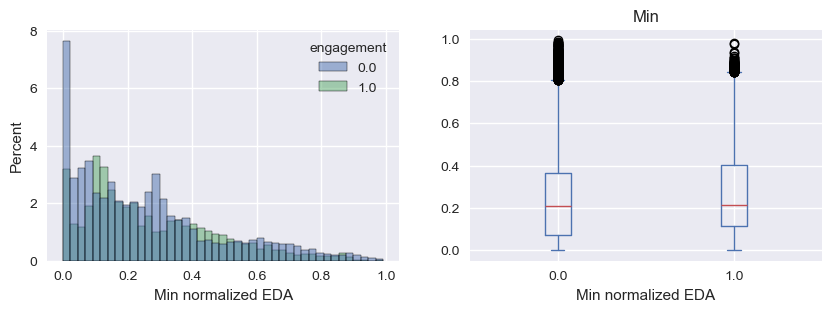

In [13]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Min",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(ax=axs[1], column="Min", by="engagement")
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

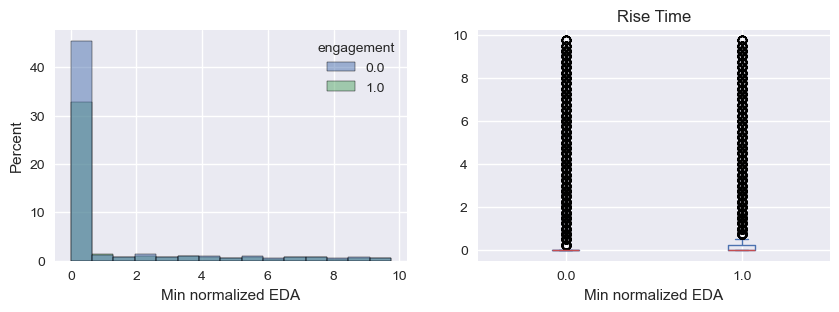

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="Rise Time",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(ax=axs[1], column="Rise Time", by="engagement")
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

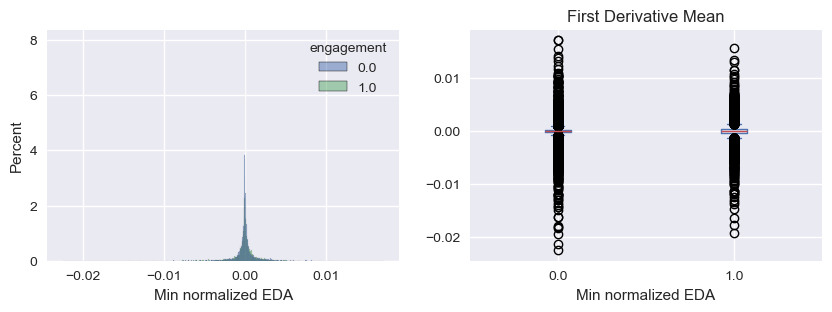

In [15]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(
    ax=axs[0],
    data=eda_features,
    x="First Derivative Mean",
    hue="engagement",
    stat="percent",
)
eda_features.plot.box(
    ax=axs[1], column="First Derivative Mean", by="engagement"
)
for ax in axs:
    ax.set_xlabel("Min normalized EDA")
plt.show()

### Let's prove some of these differences statistically.

## Statistical Tools

### • Correlation

Each features can be used to predict the engagement level. We can use the correlation coefficient to quantify this relationship.

Pearson's correlation coefficient is defined as: 
$$
r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$
where $x$ and $y$ are the two variables, and $\bar{x}$ and $\bar{y}$ are the means of $x$ and $y$ respectively.

In our case, $x$ is the feature, and $y$ is the engagement level.

In [16]:
# perform correlation
pearson_cor = eda_features.corr(method="pearson")["engagement"]
display(pearson_cor)

Min                      0.037304
Max                      0.052064
Mean                     0.046753
Std                      0.046014
Num Peaks               -0.077486
Rise Time                0.023309
Decay Time              -0.023309
Dynamic Range            0.053914
Slope                    0.002547
Absolute Slope           0.025082
First Derivative Mean    0.001051
First Derivative Std     0.066418
engagement               1.000000
Name: engagement, dtype: float64

We can also calculate other correlation coefficients. Indeed, Pearson's $\rho$ is limited in capturing only linear dependencies. Another approach is to use rank-based correlation coefficients, which are higher when two samples rise and fall together, even if this relationship is not linear.

We can use Kendall's $\tau$ correlation coefficient, defined as:
$$
\tau = \frac{n_c - n_d}{\frac{1}{2}n(n-1)}
$$
where $n_c$ is the number of concordant pairs, $n_d$ is the number of discordant pairs, and $n$ is the total number of pairs.
The number of concordant pairs is the number of pairs $(x_i, y_i)$ and $(x_j, y_j)$ such that $x_i > x_j$ and $y_i > y_j$, or $x_i < x_j$ and $y_i < y_j$. The number of discordant pairs is the number of pairs $(x_i, y_i)$ and $(x_j, y_j)$ such that $x_i > x_j$ and $y_i < y_j$, or $x_i < x_j$ and $y_i > y_j$.

In [17]:
# perform correlation
kendall_cor = eda_features.corr(method="kendall")["engagement"]
display(kendall_cor)

Min                      0.054486
Max                      0.064090
Mean                     0.061186
Std                      0.108042
Num Peaks               -0.069479
Rise Time                0.041245
Decay Time              -0.041245
Dynamic Range            0.109881
Slope                   -0.001312
Absolute Slope           0.083233
First Derivative Mean    0.003333
First Derivative Std     0.115975
engagement               1.000000
Name: engagement, dtype: float64

### • T-test

We assess if the distribution of a feature is different between the two engagement levels.

The t-test is defined as: 
$$
t = \frac{\bar{x_1} - \bar{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$
where $\bar{x_1}$ and $\bar{x_2}$ are the means of the two distributions, $s_1$ and $s_2$ are the standard deviations, and $n_1$ and $n_2$ are the number of samples.

In our case, $x_1$ and $x_2$ are the two distributions of the feature, each corresponding to a different engagement level.

In [18]:
# perform t-test between features based on the engagement level
from scipy.stats import ttest_ind


def ttest_features(x: pd.DataFrame, feature: str) -> float:
    return ttest_ind(
        x[x["engagement"] == 0][feature].values,
        x[x["engagement"] == 1][feature].values,
    )[1]


t_test_results = eda_features.apply(
    lambda x: ttest_features(eda_features, x.name), axis=0
)
t_test_results = pd.DataFrame(t_test_results, columns=["p-value"])
t_test_results["above_threshold"] = t_test_results["p-value"] < 0.05

In [19]:
display(t_test_results)

,p-value,above_threshold
Min,2.930715e-06,True
Max,6.675359e-11,True
Mean,4.598237e-09,True
Std,8.004228e-09,True
Num Peaks,2.402343e-22,True
Rise Time,3.490422e-03,True
Decay Time,3.490422e-03,True
Dynamic Range,1.380405e-11,True
Slope,7.496703e-01,False
Absolute Slope,1.671659e-03,True


We notice how the p-values of the t-test are very small, meaning that the distributions are different.

### • Effect size

Statistical tests are limited in assessing differences.

They estimate if two samples are different, but not **how much** different they are. To solve this, one could just compare averages. However, comparing the difference in averages of various features is not straightforward, since they are in different units.

To address this, one can use effect size measures. These are measures that quantify the difference between two distributions, and are unitless.

One such measure is Cliff's $\delta$, defined as:
$$
\delta = \frac{2}{n_1 n_2} \sum_{i=1}^{n_1} \sum_{j=1}^{n_2} sign(x_{1i} - x_{2j})
$$
where $x_{1i}$ and $x_{2j}$ are the samples of the two distributions, and $n_1$ and $n_2$ are the number of samples.


In [20]:
# perform cliff's delta effect size between features
from effect_size_analysis.cliff_delta import cliff_delta


def calculate_cliff_delta(
    x: DataFrame, feature: str, alpha: float = 0.05
) -> Series:
    return cliff_delta(
        s1=x[x["engagement"] == 0][feature].values,
        s2=x[x["engagement"] == 1][feature].values,
        alpha=alpha,
        accurate_ci=False,
        raise_nan=False,
    )[0]


# NOTE: this can take a while to run (around 1/2 minutes)
effect_size_results = eda_features.apply(
    lambda x: calculate_cliff_delta(eda_features, x.name), axis=0
)

In [21]:
display(effect_size_results)

Min                     -0.077813
Max                     -0.091528
Mean                    -0.087380
Std                     -0.154296
Num Peaks                0.080385
Rise Time               -0.037738
Decay Time               0.037738
Dynamic Range           -0.156923
Slope                    0.001873
Absolute Slope          -0.118867
First Derivative Mean   -0.004760
First Derivative Std    -0.165626
engagement              -1.000000
dtype: float64

What do they tell?

When $\delta < 0$, the distribution of the first sample is smaller than the distribution of the second sample.

When $\delta > 0$, the distribution of the first sample is larger than the distribution of the second sample.

When $\delta = 0$, the distributions are equal.

The $\delta$ values can also be interpreted as follows [1]:

• $|\delta| < 0.11$: negligible &nbsp;&nbsp;• $|\delta| > 0.11$: small

• $|\delta| > 0.28$: medium &nbsp;&nbsp;&nbsp;• $|\delta| > 0.43$: large

In [22]:
display(effect_size_results)

Min                     -0.077813
Max                     -0.091528
Mean                    -0.087380
Std                     -0.154296
Num Peaks                0.080385
Rise Time               -0.037738
Decay Time               0.037738
Dynamic Range           -0.156923
Slope                    0.001873
Absolute Slope          -0.118867
First Derivative Mean   -0.004760
First Derivative Std    -0.165626
engagement              -1.000000
dtype: float64

# Machine Learning

- We will make a classification of the engagement level
- Answer the question: can we predict engagement using EDA data?

## Validation Paradigms

- We need to validate our model
- There's 3 main approaches when dealing with physiological data
- Use data from the same user and same day at both train and test time.

This allows to see if the model can generalize to new inputs from the same user, but not to new users. In this case, we use as validation paradigm **5-FOLD CROSS VALIDATION**.

(Cross validation is a technique to validate a model. It consists in splitting the data in 5 parts, and using 4 parts to train the model, and the remaining part to test it. This is repeated 5 times, so that each part is used once as test set. The results are then averaged.)

- Train and test with data from different users.

In this scenario, we try to see if the model is capable of generalizing to unseen users, which might be the case when deploying our model. In this case, we use as validation paradigm **LEAVE-ONE-USER-OUT CROSS VALIDATION**.

- Use data from the same user but different days at both train and test time.

This allows to see if the model can generalize to new inputs from the same user, but not to new users. In this case, we use as validation paradigm **LEAVE ONE DAY OUT CROSS VALIDATION**.

**For the sake of this tutorial, we will not use Leave One Day Out Cross Validation**

# 5-fold cross validation

Transform our dataframe into a matrix for x and y.

In [23]:
X = eda_features.drop("engagement", axis=1).values
y = eda_features["engagement"].values

Train and validate our model using `scikit-learn` and `xgboost`.

### What is XGBoost?

XGboost is a library for gradient boosting. It is a machine learning technique that produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

# BUT

### What validation metric should we use?

Usually, when you perform a binary classification, you use the accuracy as a metric. However, this is not always the best choice. In our case, the data is not evenly distributed between the two classes. 

<Axes: >

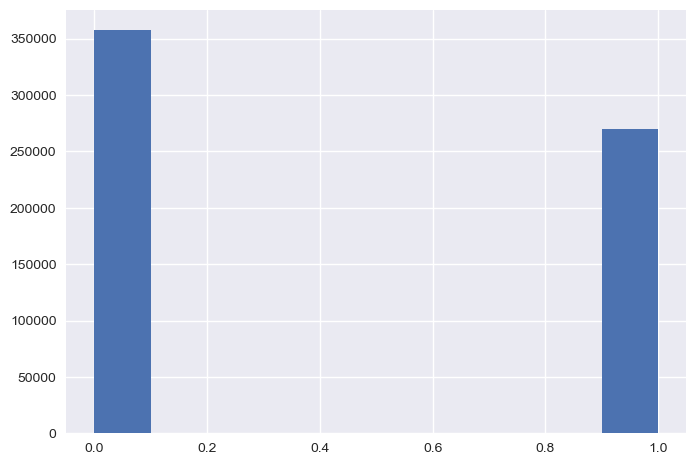

In [24]:
eda_data["engagement"].hist()

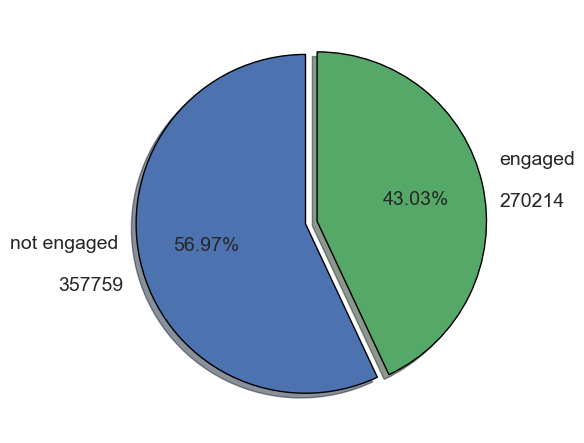

In [25]:
data = eda_data["engagement"].value_counts()
labels = ["not engaged \n\n" + str(data[0]), "engaged\n\n" + str(data[1])]


plt.pie(data, labels=labels, autopct="%1.2f%%", shadow=True,
        startangle=90, explode=(0.07, 0), textprops={'fontsize': 14},
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

plt.show()

In [26]:
eda_data.shape

(627973, 9)

We have more samples from where people are not engaged, than when they are engaged. This is called **class imbalance**.

While there are many strategies to deal with this, e.g., resampling, we will simply choose a validation metric that can account for imbalanced: **balanced accuracy**, defined as:
$$
\frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$
where $TP$ is the number of true positives, $TN$ is the number of true negatives, $FP$ is the number of false positives, and $FN$ is the number of false negatives.

We should also compare our results to a baseline classifier, i.e., a classifier which makes random guesses.

In [27]:
groups: np.ndarray = eda_features.index.get_level_values(0).values

In [28]:
# load xgboost and cross validation
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_xgboost = cross_validate(
    xgb,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

Why do we specify the groups? Since we are performing a **Stratified 5-fold CV**.

**Stratified** means that the splits are made so that the distribution of the groups is the same in the train and test sets.

In [29]:
# load random classifier and cross validation
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold

# perform cross validation with xgboost and balanced accuracy
model = DummyClassifier(strategy="uniform", random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results_dummy = cross_validate(
    model,
    X.reshape(X.shape[0], -1),
    y,
    cv=kf,
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [30]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_xgboost["test_score"]),
        100 * np.std(cv_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of Dummy: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_dummy["test_score"]),
        100 * np.std(cv_results_dummy["test_score"]),
    )
)

Average validation score of XGBoost: 63.40 ± 0.67 %
Average validation score of Dummy: 50.49 ± 0.24 %


We are doing better than random! But not much better.

### Why?

1. Limited samples used for this tutorial.
2. Difficult task.

In our experiments, using much more data, we achieve around 89% balanced accuracy in this setting.

# Leave One Subject Out Cross Validation

We need to define our groups, to perform this cross validation.

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle

X = eda_features.drop("engagement", axis=1).values
y = eda_features["engagement"].values

groups: np.ndarray = eda_features.index.get_level_values(0).values


X, y, groups = shuffle(X, y, groups, random_state=42)

# perform cross validation with xgboost and balanced accuracy
xgb = XGBClassifier(random_state=42)
baseline = DummyClassifier(strategy="uniform", random_state=42)
groups_instance = LeaveOneGroupOut()
cv_results_xgboost = cross_validate(
    xgb,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)
cv_results_dummy = cross_validate(
    baseline,
    X,
    y,
    cv=groups_instance.split(X, y, groups=groups),
    scoring="balanced_accuracy",
    return_train_score=True,
)

In [32]:
print(
    f"Average validation score of XGBoost: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_xgboost["test_score"]),
        100 * np.std(cv_results_xgboost["test_score"]),
    )
)
print(
    f"Average validation score of Dummy: %.2f ± %.2f %%"
    % (
        100 * np.mean(cv_results_dummy["test_score"]),
        100 * np.std(cv_results_dummy["test_score"]),
    )
)

Average validation score of XGBoost: 41.92 ± 16.32 %
Average validation score of Dummy: 49.83 ± 1.21 %


In this case, we are not doing better than random. Why?

**Interpersonal variability**: people are different, and this is reflected in their physiological data.

As such, right now, it is possible to predict engagement **only** if you have data from the same user.

# References

[1] Vargha, A. and Delaney, H.D., 2000. A critique and improvement of the CL common language effect size statistics of McGraw and Wong. Journal of Educational and Behavioral Statistics, 25(2), pp.101-132.

[3] Di Lascio, E., Gashi, S. and Santini, S., 2018. Unobtrusive assessment of students' emotional engagement during lectures using electrodermal activity sensors. Proceedings of the ACM on Interactive, Mobile, Wearable and Ubiquitous Technologies, 2(3), pp.1-21.

# Assignment 04

In [33]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle


models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Dummy": DummyClassifier(strategy="uniform", random_state=42),
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
}

# split in X e y
X = eda_features.drop("engagement", axis=1).values
y = eda_features["engagement"].values

# groups
groups: np.ndarray = eda_features.index.get_level_values(0).values

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_g, y_g, groups_g = shuffle(X, y, groups, random_state=42)

groups_d = eda_features.index.get_level_values(0).astype(str) + '_' + eda_features.index.get_level_values(1).astype(str)
X_d, y_d, groups_d = shuffle(X, y, groups_d, random_state=42)

cv_results = {
    "5-Fold": dict(),
    "Leave One Group Out": dict(),
    "Leave One Day Out": dict()
}

groups_instance = LeaveOneGroupOut()

# shuffle

# perform cross validation with xgboost and balanced accuracy
for model_name, model in models.items():
    print(f"\n{model_name}")
    time1 = time()
    cv_results["5-Fold"][model_name] = cross_validate(
        model,
        X.reshape(X.shape[0], -1),
        y,
        cv=kf,
        scoring="balanced_accuracy",
        return_train_score=True,
    )
    time2 = time()
    print(f"\t5-Fold: {time2-time1:.2f}s")
    cv_results["Leave One Group Out"][model_name] = cross_validate(
        model,
        X_g,
        y_g,
        cv=groups_instance.split(X_g, y_g, groups=groups_g),
        scoring="balanced_accuracy",
        return_train_score=True,
    )
    time3 = time()
    print(f"\tLeave One Group Out: {time3-time2:.2f}s")
    cv_results["Leave One Day Out"][model_name] = cross_validate(
        model,
        X_d,
        y_d,
        cv=groups_instance.split(X_d, y_d, groups=groups_d),
        scoring="balanced_accuracy",
        return_train_score=True,
    )
    print(f"\tLeave One Day Out: {time()-time3:.2f}s")



XGBoost
	5-Fold: 0.65s
	Leave One Group Out: 1.94s
	Leave One Day Out: 3.88s

Dummy
	5-Fold: 0.04s
	Leave One Group Out: 0.11s
	Leave One Day Out: 0.21s

SVM
	5-Fold: 48.45s
	Leave One Group Out: 152.02s
	Leave One Day Out: 336.00s

Random Forest
	5-Fold: 177.00s
	Leave One Group Out: 39.84s
	Leave One Day Out: 87.13s

Naive Bayes
	5-Fold: 0.04s
	Leave One Group Out: 0.13s
	Leave One Day Out: 0.26s


In [34]:
from scipy.stats import ttest_ind

test = []
test_i = []
couples = []
mod = list(cv_results.keys())

for i in range(len(mod)):
    for j in range(i+1, len(mod)):
        couples.append((mod[i], mod[j]))

for model in models:
    for cross in couples:
        for score in cv_results[cross[0]][model]:
            test_i.append((model, f"{cross[0]} vs {cross[1]}", score))
            test.append(ttest_ind(cv_results[cross[0]][model][score], cv_results[cross[1]][model][score])[1])

test_i = pd.MultiIndex.from_tuples( test_i, names=['model', 'cross', 'score'])
test_df1 = pd.DataFrame(test, index=test_i, columns=['p-value'])
test_df1["above_threshold"] = test_df1["p-value"] < 0.05

couples = []
test = []
test_i = []
mod = list(models.keys())

for i in range(len(mod)):
    for j in range(i+1, len(mod)):
        couples.append((mod[i], mod[j]))

for cv in cv_results:
    for couple in couples:
        for score in cv_results[cv][couple[0]]:
            test_i.append((cv, f"{couple[0]} vs {couple[1]}", score))
            test.append(ttest_ind(cv_results[cv][couple[0]][score], cv_results[cv][couple[1]][score])[1])


test = []
test_i = []

for cv in cv_results:
    for couple in couples:
        for score in cv_results[cv][couple[0]]:
            test_i.append((cv, f"{couple[0]} vs {couple[1]}", score))
            test.append(ttest_ind(cv_results[cv][couple[0]][score], cv_results[cv][couple[1]][score])[1])

test_i = pd.MultiIndex.from_tuples( test_i, names=['cross', 'model', 'score'])
test_df2 = pd.DataFrame(test, index=test_i, columns=['p-value'])
test_df2["above_threshold"] = test_df2["p-value"] < 0.05

## Exercise 0

In [35]:
for method in list(cv_results)[:2]:
    print(f"\n\nCross Validation: {method}\n")
    for model in list(cv_results[method].keys())[:2]:
        print(
            f"\tAverage validation score of {model}: %.2f ± %.2f %%"
            % (
                100 * np.mean(cv_results[method][model]["test_score"]),
                100 * np.std(cv_results[method][model]["test_score"]),
            ))



Cross Validation: 5-Fold

	Average validation score of XGBoost: 63.40 ± 0.67 %
	Average validation score of Dummy: 50.49 ± 0.24 %


Cross Validation: Leave One Group Out

	Average validation score of XGBoost: 41.92 ± 16.32 %
	Average validation score of Dummy: 49.83 ± 1.21 %


## Exercise 1

In [36]:
for method in cv_results:
    print(f"\n\nCross Validation: {method}\n")
    for model in list(cv_results[method].keys())[:2]:
        print(
            f"\tAverage validation score of {model}: %.2f ± %.2f %%"
            % (
                100 * np.mean(cv_results[method][model]["test_score"]),
                100 * np.std(cv_results[method][model]["test_score"]),
            ))



Cross Validation: 5-Fold

	Average validation score of XGBoost: 63.40 ± 0.67 %
	Average validation score of Dummy: 50.49 ± 0.24 %


Cross Validation: Leave One Group Out

	Average validation score of XGBoost: 41.92 ± 16.32 %
	Average validation score of Dummy: 49.83 ± 1.21 %


Cross Validation: Leave One Day Out

	Average validation score of XGBoost: 48.53 ± 16.62 %
	Average validation score of Dummy: 49.68 ± 1.19 %


## Exercise 2

In [37]:
display(test_df1.loc[(("XGBoost", "Dummy"), slice(None), slice(None)), :])

for model in test_df1.index.get_level_values(0).unique()[:2]:
    print(f"\n\nModel: {model}\n")
    for cross in test_df1.index.get_level_values(1).unique():
        print(f"\n\t{cross}")
        for score in test_df1.index.get_level_values(2).unique():
            print(f"\t\t\u00b7 {score}:\t {round(test_df1.loc[model, cross, score]['p-value'], 7)}  -   <\u03b1: {test_df1.loc[model, cross, score]['above_threshold']}")

###############

display(test_df2.loc[(slice(None), 'XGBoost vs Dummy', slice(None)), :])

for cross in test_df2.index.get_level_values(0).unique():
    print(f"\n\nCross Validation: {cross}\n")
    for model in test_df2.index.get_level_values(1).unique()[:1]:
        print(f"\n\t{model}")
        for score in test_df2.index.get_level_values(2).unique():
            print(f"\t\t\u00b7 {score}:\t {round(test_df2.loc[cross, model, score]['p-value'], 7)}  -   <\u03b1: {test_df2.loc[cross, model, score]['above_threshold']}")


p-value  \
model   cross                                    score                       
XGBoost 5-Fold vs Leave One Group Out            fit_time     5.909768e-02   
                                                 score_time   7.395021e-05   
                                                 test_score   1.355624e-02   
                                                 train_score  7.680888e-04   
        5-Fold vs Leave One Day Out              fit_time     7.295986e-02   
                                                 score_time   2.011843e-09   
                                                 test_score   6.236852e-02   
                                                 train_score  2.389205e-08   
        Leave One Group Out vs Leave One Day Out fit_time     2.879202e-01   
                                                 score_time   4.237248e-02   
                                                 test_score   2.550375e-01   
                                                 train_score  2.164468e-01   
Dummy   5-Fold vs Leave One Group Out            fit_time     8.446500e-06   
                                                 score_time   2.720946e-05   
                                                 test_score   2.701432e-01   
                                                 train_score  3.323225e-01   
        5-Fold vs Leave One Day Out              fit_time     6.175807e-03   
                                                 score_time   2.580363e-06   
                                                 test_score   1.531625e-01   
                                                 train_score  7.790918e-01   
        Leave One Group Out vs Leave One Day Out fit_time     7.002786e-01   
                                                 score_time   2.961954e-02   
                                                 test_score   7.172678e-01   
                                                 train_score  6.207283e-02   

                                                              above_threshold  
model   cross                                    score                         
XGBoost 5-Fold vs Leave One Group Out            fit_time               False  
                                                 score_time              True  
                                                 test_score              True  
                                                 train_score             True  
        5-Fold vs Leave One Day Out              fit_time               False  
                                                 score_time              True  
                                                 test_score             False  
                                                 train_score             True  
        Leave One Group Out vs Leave One Day Out fit_time               False  
                                                 score_time              True  
                                                 test_score             False  
                                                 train_score            False  
Dummy   5-Fold vs Leave One Group Out            fit_time                True  
                                                 score_time              True  
                                                 test_score             False  
                                                 train_score            False  
        5-Fold vs Leave One Day Out              fit_time                True  
                                                 score_time              True  
                                                 test_score             False  
                                                 train_score            False  
        Leave One Group Out vs Leave One Day Out fit_time               False  
                                                 score_time              True  
                                                 test_score             False  
                                      



Model: XGBoost


	5-Fold vs Leave One Group Out
		· fit_time:	 0.0590977  -   <α: False
		· score_time:	 7.4e-05  -   <α: True
		· test_score:	 0.0135562  -   <α: True
		· train_score:	 0.0007681  -   <α: True

	5-Fold vs Leave One Day Out
		· fit_time:	 0.0729599  -   <α: False
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0623685  -   <α: False
		· train_score:	 0.0  -   <α: True

	Leave One Group Out vs Leave One Day Out
		· fit_time:	 0.2879202  -   <α: False
		· score_time:	 0.0423725  -   <α: True
		· test_score:	 0.2550375  -   <α: False
		· train_score:	 0.2164468  -   <α: False


Model: Dummy


	5-Fold vs Leave One Group Out
		· fit_time:	 8.4e-06  -   <α: True
		· score_time:	 2.72e-05  -   <α: True
		· test_score:	 0.2701432  -   <α: False
		· train_score:	 0.3323225  -   <α: False

	5-Fold vs Leave One Day Out
		· fit_time:	 0.0061758  -   <α: True
		· score_time:	 2.6e-06  -   <α: True
		· test_score:	 0.1531625  -   <α: False
		· train_score:	 0.7790918  -   <α:

p-value  \
cross               model            score                       
5-Fold              XGBoost vs Dummy fit_time     2.844174e-09   
                                     score_time   3.922675e-10   
                                     test_score   3.643391e-10   
                                     train_score  1.066692e-17   
Leave One Group Out XGBoost vs Dummy fit_time     1.915661e-19   
                                     score_time   1.070702e-05   
                                     test_score   1.068790e-01   
                                     train_score  9.287072e-36   
Leave One Day Out   XGBoost vs Dummy fit_time     2.971287e-45   
                                     score_time   6.021655e-10   
                                     test_score   7.267960e-01   
                                     train_score  3.681521e-84   

                                                  above_threshold  
cross               model            score                         
5-Fold              XGBoost vs Dummy fit_time                True  
                                     score_time              True  
                                     test_score              True  
                                     train_score             True  
Leave One Group Out XGBoost vs Dummy fit_time                True  
                                     score_time              True  
                                     test_score             False  
                                     train_score             True  
Leave One Day Out   XGBoost vs Dummy fit_time                True  
                                     score_time              True  
                                     test_score             False  
                                     train_score             True



Cross Validation: 5-Fold


	XGBoost vs Dummy
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0  -   <α: True
		· train_score:	 0.0  -   <α: True


Cross Validation: Leave One Group Out


	XGBoost vs Dummy
		· fit_time:	 0.0  -   <α: True
		· score_time:	 1.07e-05  -   <α: True
		· test_score:	 0.106879  -   <α: False
		· train_score:	 0.0  -   <α: True


Cross Validation: Leave One Day Out


	XGBoost vs Dummy
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.726796  -   <α: False
		· train_score:	 0.0  -   <α: True


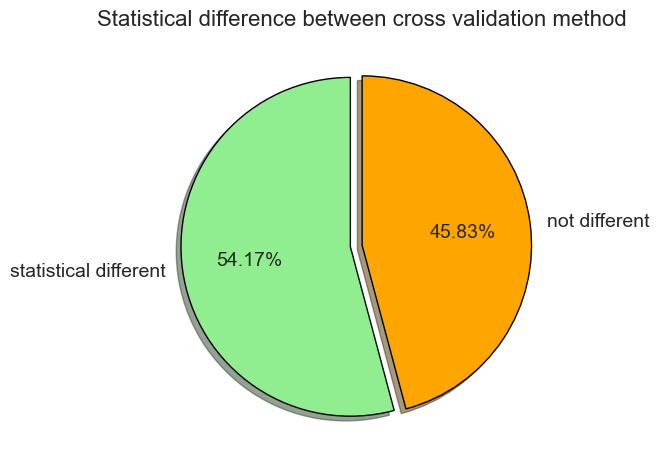

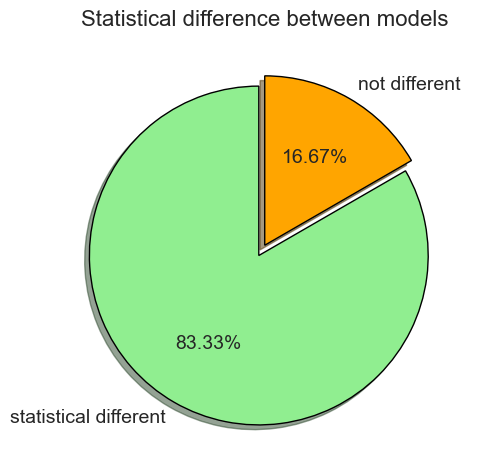

In [38]:
plt.pie(test_df1.loc[(("XGBoost", "Dummy"), slice(None), slice(None)), :]["above_threshold"].value_counts(), labels=["statistical different", "not different"], autopct="%1.2f%%", shadow=True, startangle=90, explode=(0.07, 0), textprops={'fontsize': 14}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, colors=["lightgreen", "orange"])
plt.title("Statistical difference between cross validation method", fontsize=16)
plt.show()

plt.pie(test_df2.loc[(slice(None), 'XGBoost vs Dummy', slice(None)), :]["above_threshold"].value_counts(), labels=["statistical different", "not different"], autopct="%1.2f%%", shadow=True, startangle=90, explode=(0.07, 0), textprops={'fontsize': 14}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, colors=["lightgreen", "orange"])
plt.title("Statistical difference between models", fontsize=16)
plt.show()

## Exercise 3

In [39]:
for method in cv_results:
    print(f"\n\nCross Validation: {method}\n")
    for model in cv_results[method]:
        print(
            f"\tAverage validation score of {model}: %.2f ± %.2f %%"
            % (
                100 * np.mean(cv_results[method][model]["test_score"]),
                100 * np.std(cv_results[method][model]["test_score"]),
            ))



Cross Validation: 5-Fold

	Average validation score of XGBoost: 63.40 ± 0.67 %
	Average validation score of Dummy: 50.49 ± 0.24 %
	Average validation score of SVM: 50.05 ± 0.12 %
	Average validation score of Random Forest: 63.60 ± 1.06 %
	Average validation score of Naive Bayes: 54.81 ± 1.07 %


Cross Validation: Leave One Group Out

	Average validation score of XGBoost: 41.92 ± 16.32 %
	Average validation score of Dummy: 49.83 ± 1.21 %
	Average validation score of SVM: 47.03 ± 36.52 %
	Average validation score of Random Forest: 42.00 ± 16.24 %
	Average validation score of Naive Bayes: 28.44 ± 22.48 %


Cross Validation: Leave One Day Out

	Average validation score of XGBoost: 48.53 ± 16.62 %
	Average validation score of Dummy: 49.68 ± 1.19 %
	Average validation score of SVM: 51.56 ± 44.47 %
	Average validation score of Random Forest: 48.58 ± 16.69 %
	Average validation score of Naive Bayes: 36.28 ± 21.99 %


**T-test**

In [40]:
display(test_df1)

for model in test_df1.index.get_level_values(0).unique():
    print(f"\n\nModel: {model}\n")
    for cross in test_df1.index.get_level_values(1).unique():
        print(f"\n\t{cross}")
        for score in test_df1.index.get_level_values(2).unique():
            print(f"\t\t\u00b7 {score}:\t {round(test_df1.loc[model, cross, score]['p-value'], 7)}  -   <\u03b1: {test_df1.loc[model, cross, score]['above_threshold']}")

###############

display(test_df2)

for cross in test_df2.index.get_level_values(0).unique():
    print(f"\n\nCross Validation: {cross}\n")
    for model in test_df2.index.get_level_values(1).unique():
        print(f"\n\t{model}")
        for score in test_df2.index.get_level_values(2).unique():
            print(f"\t\t\u00b7 {score}:\t {round(test_df2.loc[cross, model, score]['p-value'], 7)}  -   <\u03b1: {test_df2.loc[cross, model, score]['above_threshold']}")

p-value  \
model         cross                                    score                       
XGBoost       5-Fold vs Leave One Group Out            fit_time     5.909768e-02   
                                                       score_time   7.395021e-05   
                                                       test_score   1.355624e-02   
                                                       train_score  7.680888e-04   
              5-Fold vs Leave One Day Out              fit_time     7.295986e-02   
                                                       score_time   2.011843e-09   
                                                       test_score   6.236852e-02   
                                                       train_score  2.389205e-08   
              Leave One Group Out vs Leave One Day Out fit_time     2.879202e-01   
                                                       score_time   4.237248e-02   
                                                       test_score   2.550375e-01   
                                                       train_score  2.164468e-01   
Dummy         5-Fold vs Leave One Group Out            fit_time     8.446500e-06   
                                                       score_time   2.720946e-05   
                                                       test_score   2.701432e-01   
                                                       train_score  3.323225e-01   
              5-Fold vs Leave One Day Out              fit_time     6.175807e-03   
                                                       score_time   2.580363e-06   
                                                       test_score   1.531625e-01   
                                                       train_score  7.790918e-01   
              Leave One Group Out vs Leave One Day Out fit_time     7.002786e-01   
                                                       score_time   2.961954e-02   
                                                       test_score   7.172678e-01   
                                                       train_score  6.207283e-02   
SVM           5-Fold vs Leave One Group Out            fit_time     1.916661e-04   
                                                       score_time   1.356995e-05   
                                                       test_score   8.638345e-01   
                                                       train_score  1.401246e-01   
              5-Fold vs Leave One Day Out              fit_time     2.002283e-16   
                                                       score_time   1.116192e-22   
                                                       test_score   9.417358e-01   
                                                       train_score  2.002859e-01   
              Leave One Group Out vs Leave One Day Out fit_time     1.013118e-03   
                                                       score_time   1.968034e-05   
                                                       test_score   7.573316e-01   
                                                       train_score  1.782488e-02   
Random Forest 5-Fold vs Leave One Group Out            fit_time     1.129458e-01   
                                                       score_time   1.061635e-06   
                                                       test_score   1.280295e-02   
                                                       train_score  5.682002e-01   
              5-Fold vs Leave One Day Out              fit_time     1.942006e-02   
                                                       score_time   1.523592e-24   
                                                       test_score   6.089737e-02   
                                                       train_score  5.032301e-01   
              Leave One Group Out vs Leave One Day Out fit_time     4.653068e-05   
                                                       score_time   9.448136e-06   
                                         



Model: XGBoost


	5-Fold vs Leave One Group Out
		· fit_time:	 0.0590977  -   <α: False
		· score_time:	 7.4e-05  -   <α: True
		· test_score:	 0.0135562  -   <α: True
		· train_score:	 0.0007681  -   <α: True

	5-Fold vs Leave One Day Out
		· fit_time:	 0.0729599  -   <α: False
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0623685  -   <α: False
		· train_score:	 0.0  -   <α: True

	Leave One Group Out vs Leave One Day Out
		· fit_time:	 0.2879202  -   <α: False
		· score_time:	 0.0423725  -   <α: True
		· test_score:	 0.2550375  -   <α: False
		· train_score:	 0.2164468  -   <α: False


Model: Dummy


	5-Fold vs Leave One Group Out
		· fit_time:	 8.4e-06  -   <α: True
		· score_time:	 2.72e-05  -   <α: True
		· test_score:	 0.2701432  -   <α: False
		· train_score:	 0.3323225  -   <α: False

	5-Fold vs Leave One Day Out
		· fit_time:	 0.0061758  -   <α: True
		· score_time:	 2.6e-06  -   <α: True
		· test_score:	 0.1531625  -   <α: False
		· train_score:	 0.7790918  -   <α:

p-value  \
cross             model                        score                       
5-Fold            XGBoost vs Dummy             fit_time     2.844174e-09   
                                               score_time   3.922675e-10   
                                               test_score   3.643391e-10   
                                               train_score  1.066692e-17   
                  XGBoost vs SVM               fit_time     3.821638e-18   
...                                                                  ...   
Leave One Day Out SVM vs Naive Bayes           train_score  4.798792e-21   
                  Random Forest vs Naive Bayes fit_time     2.001210e-78   
                                               score_time   6.712461e-33   
                                               test_score   2.724030e-02   
                                               train_score  6.308583e-74   

                                                            above_threshold  
cross             model                        score                         
5-Fold            XGBoost vs Dummy             fit_time                True  
                                               score_time              True  
                                               test_score              True  
                                               train_score             True  
                  XGBoost vs SVM               fit_time                True  
...                                                                     ...  
Leave One Day Out SVM vs Naive Bayes           train_score             True  
                  Random Forest vs Naive Bayes fit_time                True  
                                               score_time              True  
                                               test_score              True  
                                               train_score             True  

[120 rows x 2 columns]



Cross Validation: 5-Fold


	XGBoost vs Dummy
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0  -   <α: True
		· train_score:	 0.0  -   <α: True

	XGBoost vs SVM
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0  -   <α: True
		· train_score:	 0.0  -   <α: True

	XGBoost vs Random Forest
		· fit_time:	 0.315403  -   <α: False
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.7556533  -   <α: False
		· train_score:	 0.0  -   <α: True

	XGBoost vs Naive Bayes
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 8e-07  -   <α: True
		· train_score:	 0.0  -   <α: True

	Dummy vs SVM
		· fit_time:	 0.0  -   <α: True
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0097627  -   <α: True
		· train_score:	 0.267627  -   <α: False

	Dummy vs Random Forest
		· fit_time:	 0.3139019  -   <α: False
		· score_time:	 0.0  -   <α: True
		· test_score:	 0.0  -   <α: True
		· train_sc

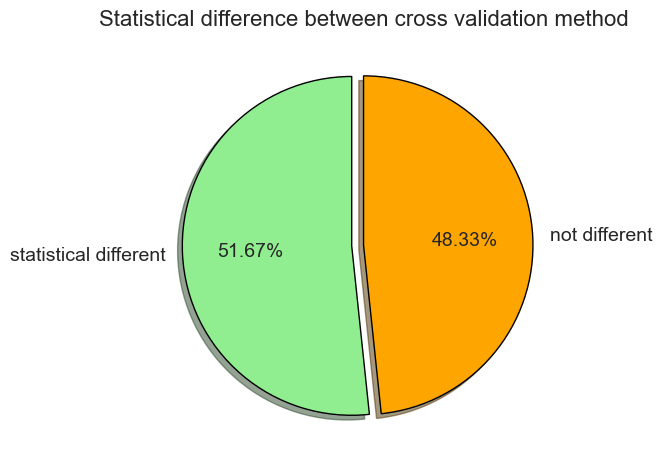

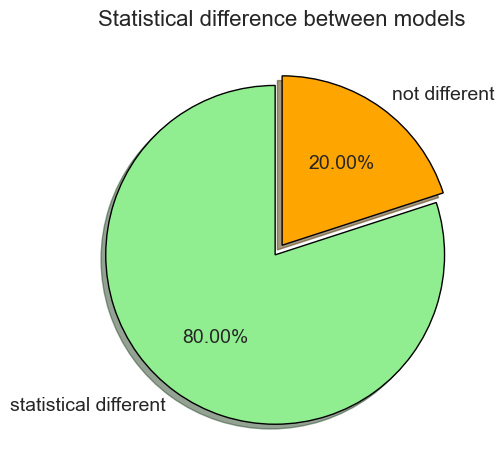

In [41]:
plt.pie(test_df1["above_threshold"].value_counts(), labels=["statistical different", "not different"], autopct="%1.2f%%", shadow=True, startangle=90, explode=(0.07, 0), textprops={'fontsize': 14}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, colors=["lightgreen", "orange"])
plt.title("Statistical difference between cross validation method", fontsize=16)
plt.show()

plt.pie(test_df2["above_threshold"].value_counts(), labels=["statistical different", "not different"], autopct="%1.2f%%", shadow=True, startangle=90, explode=(0.07, 0), textprops={'fontsize': 14}, wedgeprops={'linewidth': 1, 'edgecolor': 'black'}, colors=["lightgreen", "orange"])
plt.title("Statistical difference between models", fontsize=16)
plt.show()